<a href="https://colab.research.google.com/github/neuralsrg/LinearAlgebra/blob/main/signal_processing/wavelet_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Morlet wavelet

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import IPython
from tqdm import trange
import pywt
from google.colab import files

To get morlet wavelet we have to element-wise multiply `sin` and `gaussian`.


Then, given complex morlet wavelet, we can convolve it with EEG data.

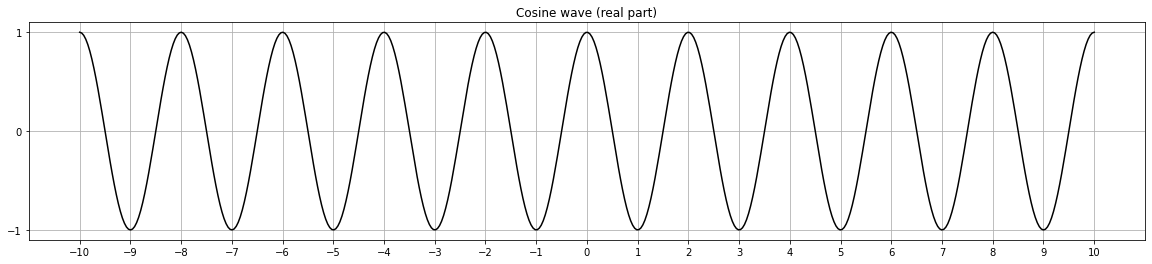

In [ ]:
t = np.linspace(-10, 10, 500)
frequency = 0.5 # Hz
comp = np.exp(2*np.pi*1j*frequency*t)

plt.figure(figsize=(20, 4))
plt.plot(t, comp.real, c='black')
plt.title('Cosine wave (real part)')
plt.ylim([-1.1, 1.1])
plt.yticks([-1, 0, 1])
plt.xticks(np.arange(-10, 11))
plt.grid()

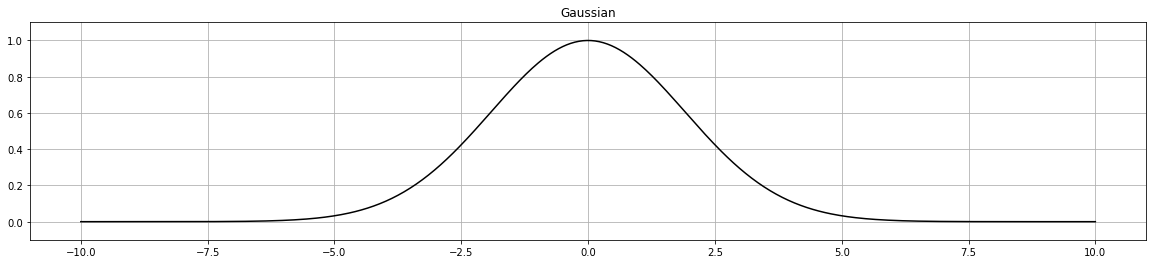

In [ ]:
n = 6 # number of cycles
sigma = n/(2*np.pi*frequency)
gaussian = np.exp(-.5*(t/sigma)**2)

plt.figure(figsize=(20, 4))
plt.plot(t, gaussian, c='black')
plt.title('Gaussian')
plt.ylim([-0.1, 1.1])
plt.grid()

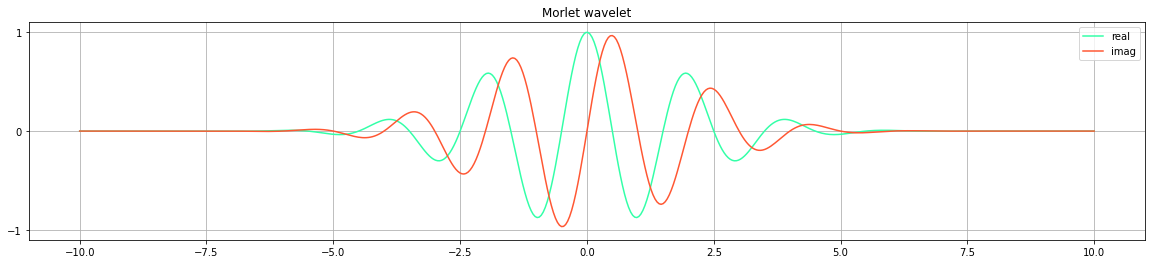

In [ ]:
morlet = gaussian * comp

plt.figure(figsize=(20, 4))
plt.plot(t, morlet.real, c='#33FFA8', label='real')
plt.plot(t, morlet.imag, c='#FF5733', label='imag')
plt.title('Morlet wavelet')
plt.ylim([-1.1, 1.1])
plt.legend()
plt.yticks([-1, 0, 1])
plt.grid()

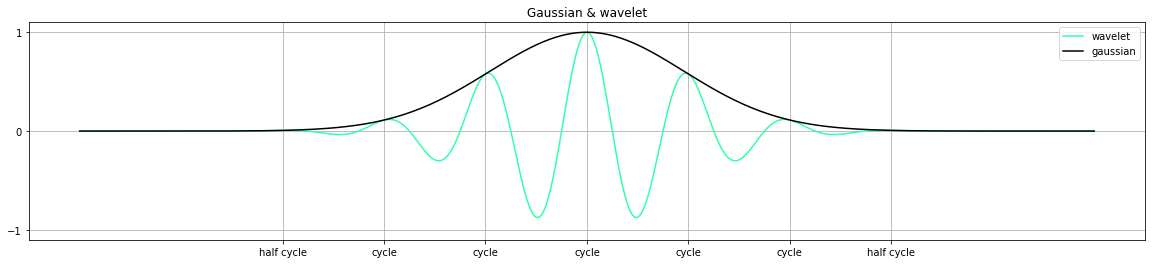

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(t, morlet.real, c='#33FFA8', label='wavelet')
plt.plot(t, gaussian, c='black', label='gaussian')
plt.title('Gaussian & wavelet')
plt.ylim([-1.1, 1.1])
plt.legend()
plt.yticks([-1, 0, 1])
plt.xticks(np.arange(-n//2, n//2 + 1) / frequency, labels=['half cycle'] +\
                                                ['cycle']*(n-1) + ['half cycle'])
plt.grid()

## Putting all together:

*   morlet wavelet:
$$
w = e^{2\pi ift - .5\frac{-t^2}{\sigma ^2}}
$$

$$
\sigma = \frac{n}{2\pi f},
$$
where `n` is a number of cycles

In [ ]:
def get_morlet(n : int, frequency : float):
  # 1. compute complex sine wave
  # t = np.linspace(-1, 1, 1000)
  t = np.linspace(-1, 1, 1000)
  comp = np.exp(2*np.pi*1j*frequency*t)

  # 2. compute gaussian
  sigma = n/(2*np.pi*frequency)
  gaussian = np.exp(-.5*(t/sigma)**2)

  morlet = comp * gaussian

  return morlet.real, gaussian, t

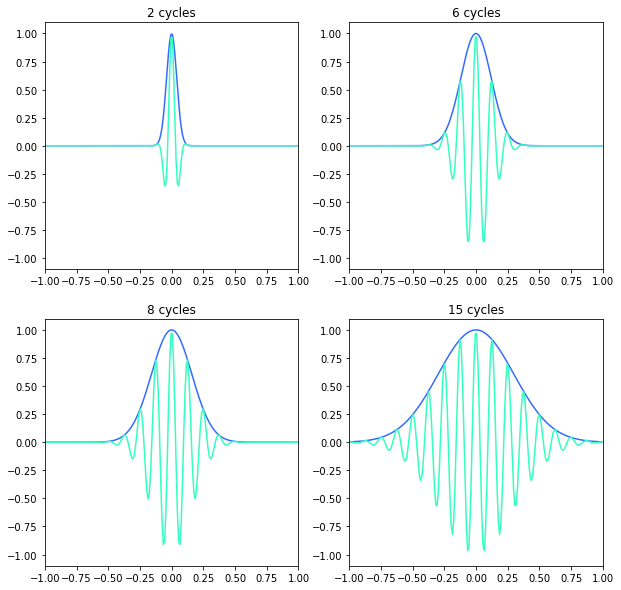

In [ ]:
n = [2, 6, 8, 15]
freq = 8 

fig = plt.figure(figsize=(10, 10))
for i in range(4):
  wavelet, gaussian, t = get_morlet(n[i], freq)
  ax = fig.add_subplot(2, 2, i+1)
  ax.set_title(f'{n[i]} cycles')
  ax.plot(t, gaussian, c='#336BFF')
  ax.plot(t, wavelet, c='#33FFBE')
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1, 1])

The more cycles we take, the larger time window with non-zero energy is & the smaller frequency window is.

But the less cycles we take, the smaller time window with non-zero energy is & the larger frequency window is.

the larger gaussian in frequency domain is.

Here comes the `time-frequency trade-off`

## Time-frequency trade-off

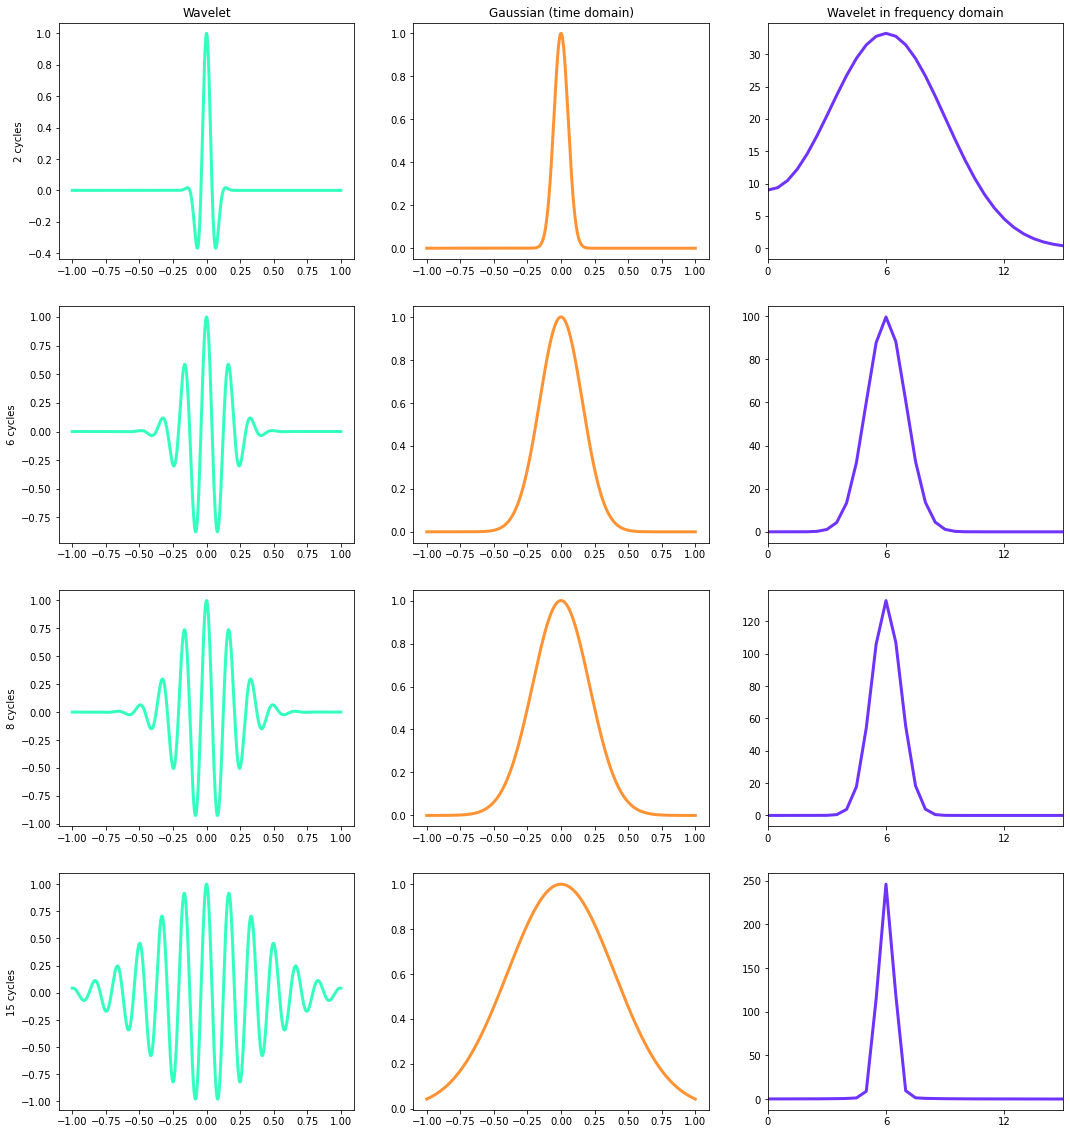

In [ ]:
fig = plt.figure(figsize=(18, 20))
freq = 6

for i in range(4):
  wavelet, gaussian, t = get_morlet(n[i], freq)

  ax = fig.add_subplot(4, 3, i * 3 + 1)
  if i == 0:
    ax.set_title('Wavelet')
  ax.plot(t, wavelet, c='#33FFBE', linewidth=3)
  plt.ylabel(f'{n[i]} cycles')

  ax = fig.add_subplot(4, 3, i * 3 + 2)
  if i == 0:
    ax.set_title('Gaussian (time domain)')
  ax.plot(t, gaussian, c='#FF9333', linewidth=3)

  ax = fig.add_subplot(4, 3, i * 3 + 3)
  if i == 0:
    ax.set_title('Wavelet in frequency domain')
  fft = np.fft.fft(wavelet)
  freqs = np.fft.fftfreq(wavelet.shape[0], .002) # 1000 samples in 2 sec gives us period=.002
  plt.xlim([0, 15])
  plt.xticks([0, 6, 12])
  ax.plot(freqs[:500], np.abs(fft[:500]), c='#6E33FF', linewidth=3)

## Wavelet transform


#### Convolution theorem

![image](https://i.imgur.com/3z5zYkU.png)


Further in the code I will use the second approach

In [2]:
# load .wav file
files.upload()
IPython.display.Audio('data.wav')

Saving data.wav to data (1).wav


In [3]:
sr, data = wavfile.read('data.wav')

# number of seconds for wavelet 
seconds = data.shape[0] / sr
sr, data.shape

(16000, (41602,))

## 1 step of continuous wavelet transform

In [6]:
# signal in frequency domain
freq_sig = np.fft.fft(data)

# wavelet
t = np.linspace(-seconds / 2, seconds / 2, data.shape[0])
frequency = 200
n = 6 
comp = np.exp(2*np.pi*1j*frequency*t)
sigma = n/(2*np.pi*frequency)
gaussian = np.exp(-.5*(t/sigma)**2)

wavelet = comp * gaussian
freq_wavelet = np.fft.fft(wavelet.real)

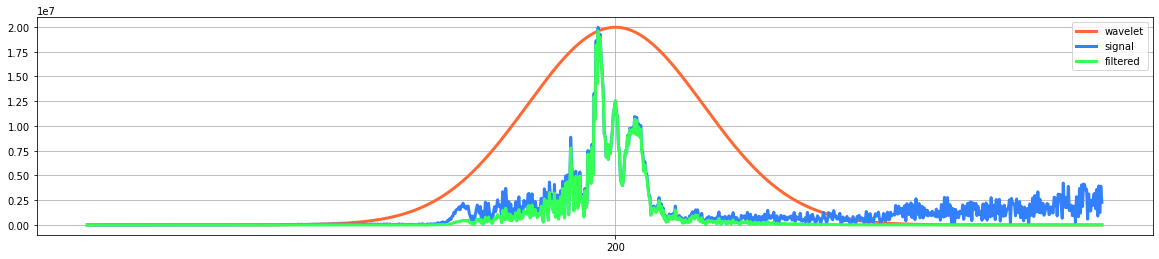

In [7]:
freqs = np.fft.fftfreq(data.shape[0], 1/sr)

freq_wavelet /= np.max(np.abs(freq_wavelet))
freq_wavelet_plot = freq_wavelet * np.max(np.abs(freq_sig))

filtered = freq_wavelet * freq_sig

x = 1000 # points to plot

plt.figure(figsize=(20, 4))

plt.plot(freqs[:x], np.abs(freq_wavelet_plot)[:x], label='wavelet', c='#FF6833', linewidth=3)
plt.plot(freqs[:x], np.abs(freq_sig)[:x], label='signal', c='#3380FF', linewidth=3)
plt.plot(freqs[:x], np.abs(filtered)[:x], label='filtered', c='#33FF55', linewidth=3)

plt.xticks([frequency])
plt.grid()
plt.legend()

In [8]:
restored = np.fft.ifft(filtered)
scaled = np.int16(restored.real/np.max(np.abs(restored)) * 32767)
wavfile.write('test.wav', sr, scaled)
IPython.display.Audio('test.wav')

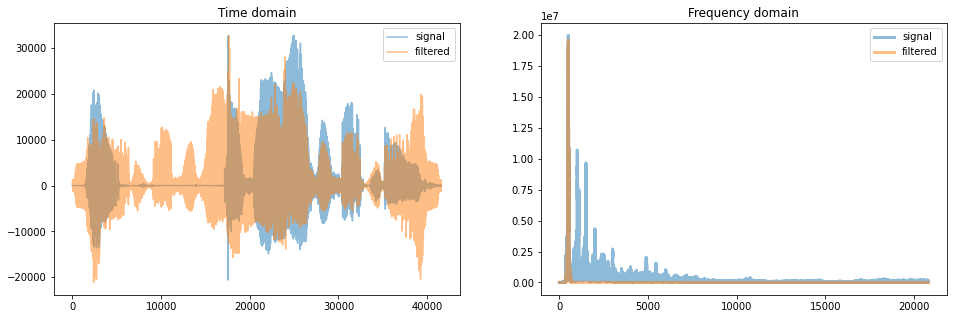

In [9]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)

restored = np.fft.ifft(freq_sig)
scaled = np.int16(restored.real/np.max(np.abs(restored)) * 32767)
ax.plot(scaled, alpha=.5, label='signal')

restored = freq_sig.real + 1j * filtered.imag
restored = np.fft.ifft(restored) ###############
scaled = np.int16(restored.real/np.max(np.abs(restored)) * 32767)
ax.plot(scaled, alpha=.5, label='filtered')
plt.title('Time domain')
plt.legend()

ax = fig.add_subplot(122)
ax.plot(np.abs(freq_sig)[:freq_sig.shape[0] // 2], linewidth=3, alpha=.5, label='signal')
ax.plot(np.abs(filtered)[:freq_sig.shape[0] // 2], linewidth=3, alpha=.5, label='filtered')
plt.title('Frequency domain')
plt.legend()

## Spectrogram representation

In [91]:
def plot_spectrogram(S, sr, hop_length, y_axis='linear'):
  plt.figure(figsize=(25, 10))
  S = librosa.power_to_db(S)
  librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
  plt.colorbar()

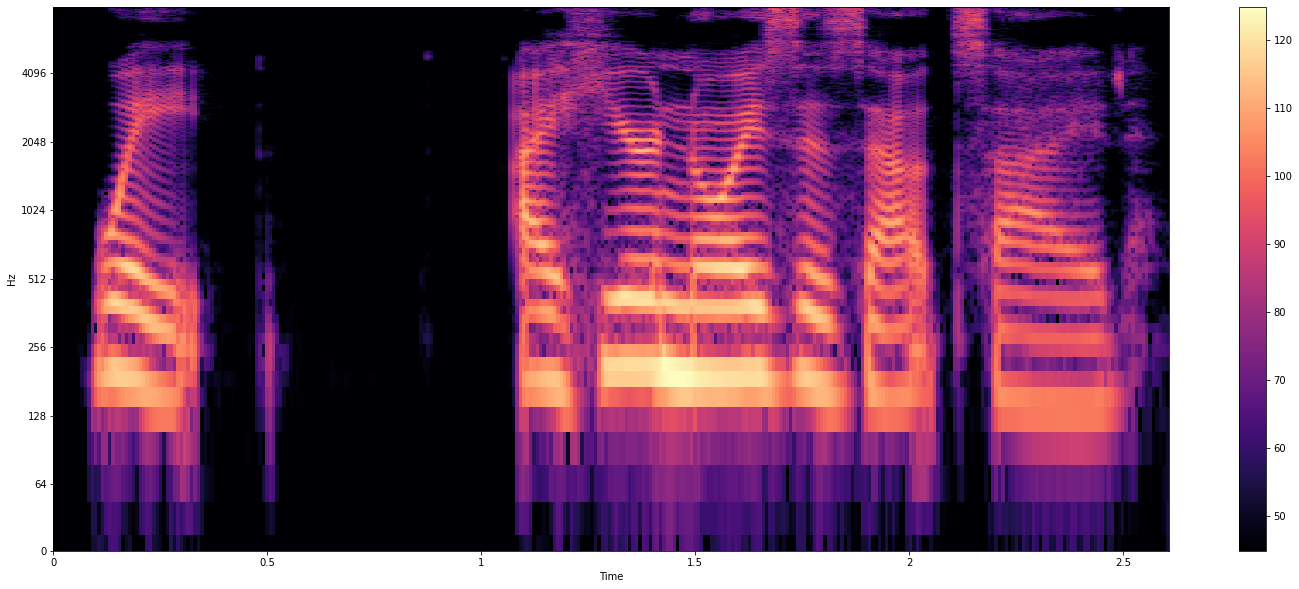

In [93]:
x = librosa.stft(data.astype(float), n_fft=512, hop_length=128)
plot_spectrogram(np.abs(x) ** 2, sr=sr, hop_length=128, y_axis='log')

## CWT with pywt library 

In [10]:
scales = 4000 / np.linspace(1, 4000, 500)[::-1]
name = "cmor0.2-0.25" 
# 0.2 stands for brandwidth parameter
# 0.25 stands for the starting frequency = 0.25 * sr
sampling_period = 1. / sr

cwt, freqs = pywt.cwt(data=data, scales=scales, wavelet=name,
                      sampling_period=sampling_period)

cwt.shape, freqs.shape

((500, 41602), (500,))

In [11]:
freqs[:16]

array([4000.        , 3991.98597194, 3983.97194389, 3975.95791583,
       3967.94388778, 3959.92985972, 3951.91583166, 3943.90180361,
       3935.88777555, 3927.87374749, 3919.85971944, 3911.84569138,
       3903.83166333, 3895.81763527, 3887.80360721, 3879.78957916])

cmor3.5-0.25

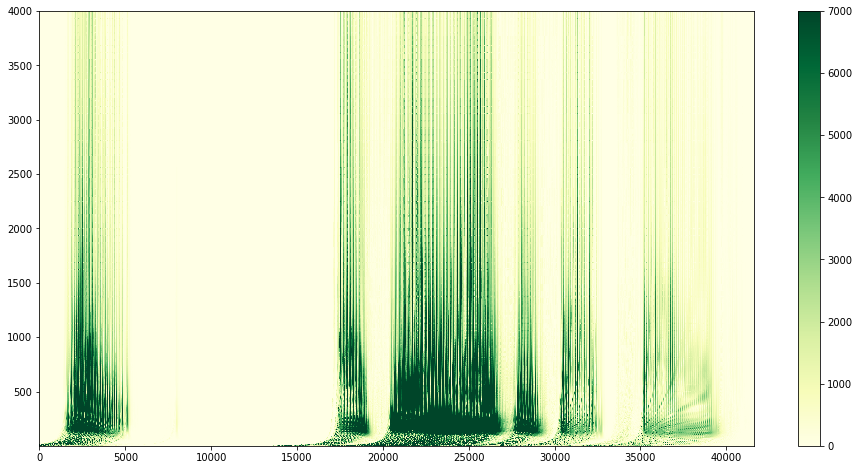

In [9]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=7000, clip=True)
plt.figure(figsize=(16, 8))
plt.pcolormesh(np.arange(data.shape[0]), freqs, np.abs(cwt), shading='flat',
               norm=norm, cmap='YlGn')
plt.colorbar()

cmor1.5-0.25

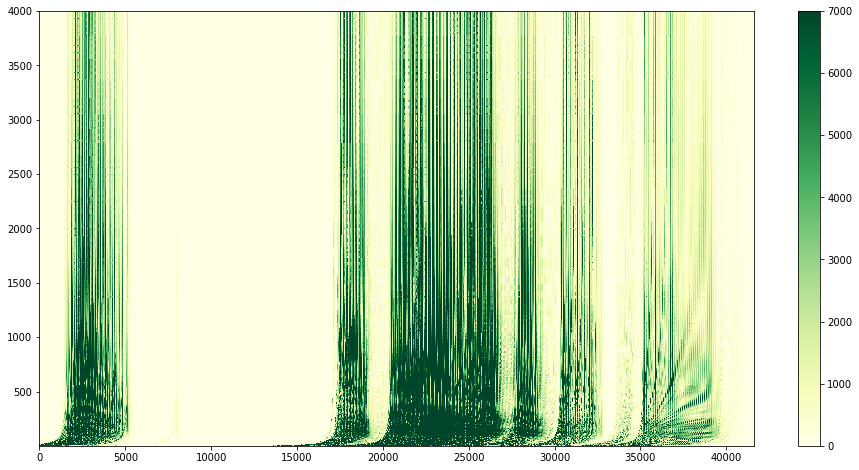

In [6]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=7000, clip=True)
plt.figure(figsize=(16, 8))
plt.pcolormesh(np.arange(data.shape[0]), freqs, np.abs(cwt), shading='flat',
               norm=norm, cmap='YlGn')
plt.colorbar()

cmor0.2-0.25

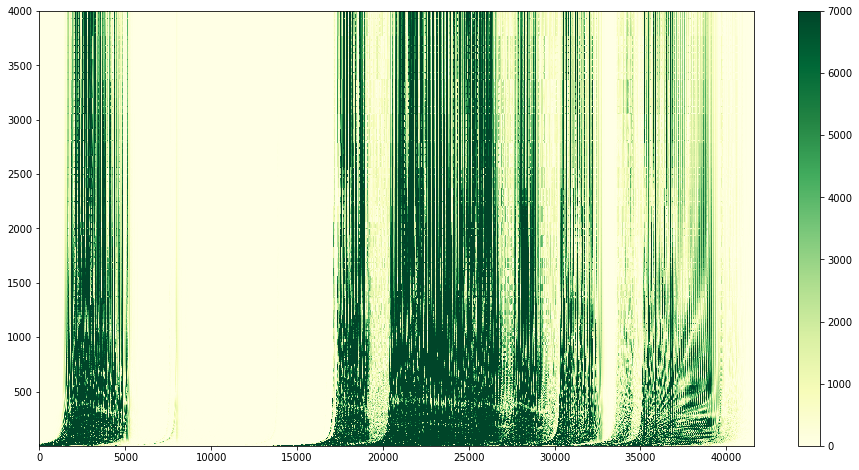

In [12]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=7000, clip=True)
plt.figure(figsize=(16, 8))
plt.pcolormesh(np.arange(data.shape[0]), freqs, np.abs(cwt), shading='flat',
               norm=norm, cmap='YlGn')
plt.colorbar()

## Example of CWT manual implementation

(It might work incorrect, do not use this implementation)

In [81]:
# signal in frequency domain
freq_sig = np.fft.fft(data)

t = np.linspace(-seconds / 2, seconds / 2, data.shape[0])
n = 6

total_freqs = 1000
morlet_spec = np.zeros(shape=(total_freqs, data.shape[0]))

for freq in trange(total_freqs):

  # wavelet
  comp = np.exp(2*np.pi*1j*freq*t)
  sigma = n/(2*np.pi*(freq + 1))
  gaussian = np.exp(-.5*(t/sigma)**2)
  
  wavelet = comp * gaussian
  freq_wavelet = np.fft.fft(wavelet.real)
  # scale so that freq_wavelet matches freq_sig
  freq_wavelet /= np.max(np.abs(freq_wavelet))

  # multiply
  filtered = freq_wavelet * freq_sig
  reversed = np.fft.ifft(filtered)
  reversed = np.abs(reversed) ** 2
  morlet_spec[i] = reversed

morlet_spec.shape

100%|██████████| 1000/1000 [00:17<00:00, 58.48it/s]


(1000, 41602)

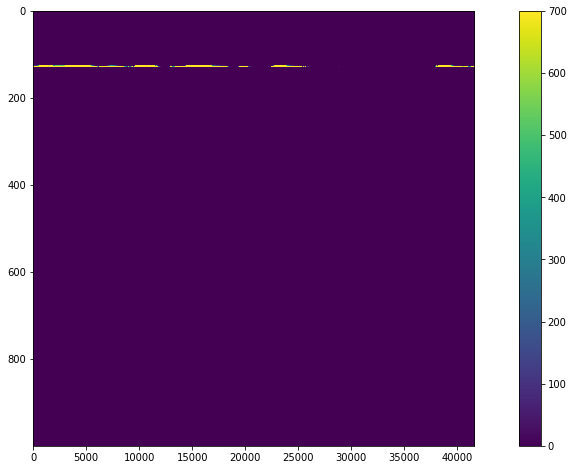

In [90]:
# ?
plt.figure(figsize=(16, 8))
plt.imshow(morlet_spec, aspect=41., vmax=700)
plt.colorbar()